### Import Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Đọc dataset

In [4]:
def readData(file_train,file_test):
    df_train=pd.read_csv(file_train)
    df_test=pd.read_csv(file_test)
    train_X=df_train.iloc[:,1:]
    train_Y=df_train.iloc[:,0]
    test_X=df_test.iloc[:,1:]
    test_Y=df_test.iloc[:,0]
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)

In [5]:
train_X, train_Y, test_X, test_Y=readData('./fashion-mnist_train.csv','./fashion-mnist_test.csv')

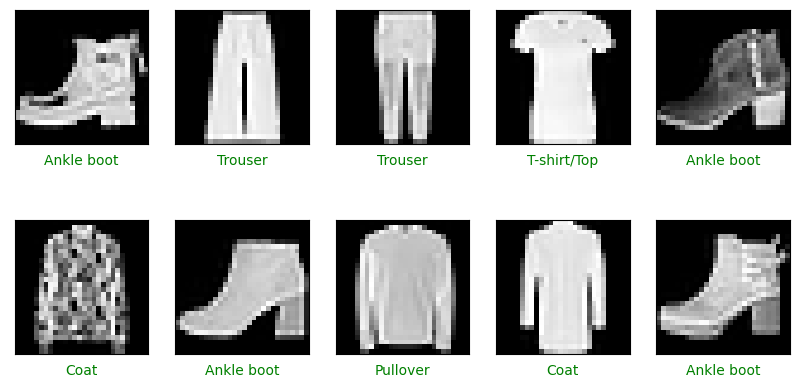

In [7]:
Class_label=['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle boot']
rand_arr=np.random.choice(range(train_X.shape[0]),10)
plt.figure(figsize=(10,5))
for i, index in enumerate(rand_arr):
    plt.subplot(2,5,i+1)
    plt.imshow(train_X[index].reshape(28,28),cmap='gist_gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(Class_label[train_Y[index]],color='green')

### Khám phá dữ liệu 

In [8]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [9]:
np.unique(train_Y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

### Tiền xử lý dữ liệu

In [10]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

In [11]:
def scale(X):# min max scale to 0-1
    return (X - X.min()) / (X.max() - X.min())

In [12]:
def normalize(X):# z_score normalize
    normalized = (X - (X).mean(axis=0)) / (X).std(axis=0)
    normalized[normalized != normalized] = 0
    return normalized

Ta thử thiết kế ra ma trận đầu vào $\textbf{X news}$ thay cho ma trận đầu vào $\textbf{X}$ sao cho ma trận đầu vào $\textbf{X news}$ sẽ giúp mô hình Softmax Regression dự đoán đầu ra $Y$ tốt hơn hơn. Cụ thể ở đây, ta sẽ thử một cách thiết kế đơn giản cho ma trận đầu vào $\textbf{X news}$: $\textbf{X news}$ là $\textbf{X}$ (chứa các giá trị pixel) được bổ sung thêm 2 đặc trưng là "intensity" và "symmetry".

- "intensity" của một ảnh cho biết giá trị pixel trung bình của ảnh; đặc trưng này có thể giúp ích cho việc phân tách giữa các hình vì các áo quần, giày dép ít vải hơn ("intensity" thấp) và có các áo quần, giày dép nhiều vải hơn ("intensity" cao).
- "symmetry" của ảnh cho biết mức độ đối xứng của ảnh; đặc trưng này cũng có thể giúp ích cho việc phân tách giữa các trang phục vì giày dép mức độ đối xứng thấp hơn áo quần và độ đối xứng giữa các áo quần tay dài và ngắn cũng khác nhau. Cụ thể, "symmetry" của ảnh được tính như sau:
    - Lấy ảnh trừ đi ảnh lật theo chiều ngang, lấy trị tuyệt đối, rồi tính trung bình. Gọi kết quả tính được là s1
    - Lấy ảnh trừ đi ảnh lật theo chiều dọc, lấy trị tuyệt đối, rồi tính trung bình. Gọi kết quả tính được là s2
    - symmetry = - (s1 + s2) / 2

In [13]:
def add_features(X):
    intens = (X.sum(axis=1)/X.shape[1]).reshape(-1,1)
    symm = np.array([])
    for i in range(X.shape[0]):
        img = X[i].reshape(28,28)
        s1 = np.sum(np.abs(img - np.flip(img,axis=0)))/X.shape[1]
        s2 = np.sum(np.abs(img - np.flip(img,axis=1)))/X.shape[1]
        symm_element = -(s1+s2)/2
        symm = np.append(symm, symm_element)
    symm = symm.reshape(-1,1)
    mins = np.array([np.min(intens),np.min(symm)])
    maxs = np.array([np.max(intens),np.max(symm)])
    max_min = maxs-mins
    intens = (intens - mins[0])/max_min[0]
    symm = (symm - mins[1])/max_min[1]
    add_col = np.hstack((intens, symm))
    X = np.hstack((X,add_col))
    return X
    

In [14]:
Train_X_new = add_features(scale(train_X))

In [15]:
Train_X_new = add_ones(Train_X_new)
print(Train_X_new.shape)

(60000, 787)


In [16]:
print(f'Min of train_X: {Train_X_new.min()}, max of train_X: {Train_X_new.max()}')

Min of train_X: 0.0, max of train_X: 1.0


In [17]:
Train_X_new[Train_X_new != 0]

array([1.        , 0.01568627, 0.24313725, ..., 0.16078431, 0.37049095,
       0.75318837])

### Mô hình Softmax Regression

Hàm softmax cho dữ liệu
- Input: Giá trị đầu vào Z (X*W)
- Output: Giá trị xác suất sau khi được tính toán bởi hàm soft max

In [18]:
def softmax(z):
    exp_Z = np.exp(z - np.max(z, axis=1, keepdims=True))
    sum_mau = np.sum(exp_Z, axis=1).reshape(-1,1)
    sft = exp_Z / sum_mau
    return sft

Hàm trả về toàn bộ layer
- Input: Giá trị đầu vào Z (X*W)
- Output: Giá trị xác suất của toàn bộ layer

In [19]:
def compute_output_all_layer(Z):
    return softmax(Z)

Hàm trả về max layer
- Input: Giá trị đầu vào Z (X*W)
- Output: Giá trị xác suất lớn nhất layer

In [20]:
def compute_output_max_layer(Z):
    return np.argmax(softmax(Z), axis=1)

Hàm trả về độ lỗi (tỉ lệ dự đoán sai %)
- Input: Giá trị dự đoán, giá trị thực
- Output: Tỉ lệ dự đoán sai so với giá trị thực

In [21]:
def compute_mbe(predicted_y, y, N):
    return np.sum(predicted_y != y) / N * 100

Hàm tính cross entropy
- Input: Giá trị đầu vào one-hot vector, giá trị xác suất của layer
- Output: Cross entropy của layer

In [22]:
def cross_entropy(p, t):
    return -np.sum(p * np.log(t))

Hàm chuyển ma trận mục tiêu thành ma trận one-hot
- Input: Dữ liệu mục tiêu
- Output: Dự liệu mục tiêu dạng one-hot

In [23]:
def one_hot_transform(y,num_class):
    return np.eye(num_class)[y]

Hàm chia mini-batch
- Input: Dữ liệu huấn luyện X, dữ liệu one-hot y, độ lớn của batch, tập hợp của vị trí của các dòng dữ liệu X
- Output: Các batch ngẫu nhiên

In [24]:
def implement_minibatches(inputs, targets, batchsize, indices):
    np.random.shuffle(indices)
    for start_ID in range(0, len(indices) - batchsize + 1, batchsize):
        wanted = indices[start_ID:start_ID + batchsize]
        yield inputs[wanted], targets[wanted]

Hàm tính gradient desent cho mini-batch
- Input: Giá trị dự đoán, giá trị thực, dữ liệu X, độ lớn của batch
- Output: Giá trị gradient desent

In [25]:
def compute_grad(Pred,Actula,X,minibat_size):
    return (1 / minibat_size) * X.T@(Pred - Actula)

Hàm train dữ liệu

In [26]:
def train_smreg(X, y, mb_size, lr, max_epoch, wanted_mbe):
    N, D = X.shape
    n_class = len(np.unique(y))
    W = np.zeros((D, n_class))
    y_one_hot = one_hot_transform(y, n_class)
    cross_entropy_losses = []
 
    indices = np.arange(N)
    for epoch in range(max_epoch):
        mini_batches = implement_minibatches(X, y_one_hot, mb_size, indices)
        for batch in mini_batches:
            x_mb, y_mb = batch
            Z = x_mb@W
            probs = compute_output_all_layer(Z)
            grad = compute_grad(probs,y_mb,x_mb,mb_size)
            W -= lr * grad
        
        Z = X@W
        # Tính cross entropy loss
        probs = compute_output_all_layer(Z)
        cross_entropy_loss = 1/N * cross_entropy(y_one_hot, probs)
        cross_entropy_losses = np.append(cross_entropy_losses, cross_entropy_loss)
 
        # Tính mbe
        predicted_y = compute_output_max_layer(Z)
        mbe = compute_mbe(predicted_y, y, N)
        print('mbe:',mbe)
        if mbe <= wanted_mbe:
            break

    return W, cross_entropy_losses

def predict(W, X):
    X_new = add_features(scale(X))
    X_new = add_ones(X_new)
    Z = X_new@W
    preds = compute_output_max_layer(Z)
    return preds

def accuracy(y_pred, y_test):
    return 1 - compute_mbe(y_pred,y_test,len(y_test))/100

### Test dữ liệu

### Softmax with GD

mbe: 69.11666666666667
mbe: 55.276666666666664
mbe: 46.800000000000004
mbe: 41.38666666666666
mbe: 38.263333333333335
mbe: 36.483333333333334
mbe: 35.58833333333333
mbe: 34.945
mbe: 34.596666666666664
mbe: 34.325
mbe: 34.178333333333335
mbe: 34.04
mbe: 33.98833333333333
mbe: 33.95333333333333
mbe: 33.928333333333335
mbe: 33.858333333333334
mbe: 33.815
mbe: 33.76833333333333
mbe: 33.751666666666665
mbe: 33.72
mbe: 33.695
mbe: 33.663333333333334
mbe: 33.64333333333333
mbe: 33.62833333333333
mbe: 33.60666666666667
mbe: 33.575
mbe: 33.538333333333334
mbe: 33.5
mbe: 33.483333333333334
mbe: 33.46666666666667
mbe: 33.44
mbe: 33.41833333333334
mbe: 33.39833333333333
mbe: 33.38333333333333
mbe: 33.34666666666667
mbe: 33.29666666666667
mbe: 33.263333333333335
mbe: 33.233333333333334
mbe: 33.196666666666665
mbe: 33.15
mbe: 33.105000000000004
mbe: 33.05833333333334
mbe: 33.00833333333333
mbe: 32.95666666666667
mbe: 32.928333333333335
mbe: 32.87
mbe: 32.803333333333335
mbe: 32.736666666666665
mbe: 

Text(0, 0.5, 'Log (for clarity) of training cross-entropy')

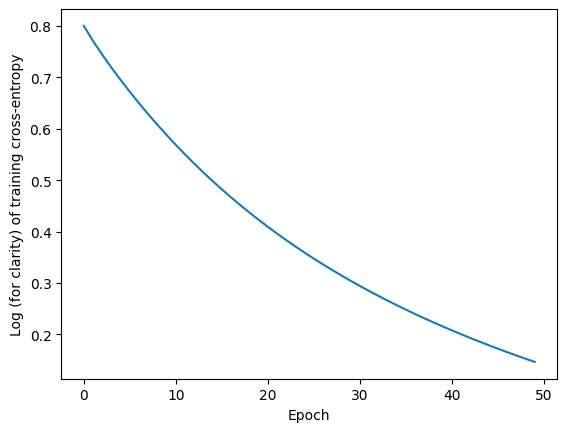

In [27]:
%%time
W_GD, train_ces = train_smreg(
    Train_X_new, train_Y, mb_size=len(Train_X_new), lr=0.03, max_epoch=50, wanted_mbe=12)
# print(W_3a)
print(train_ces)
plt.plot(np.log(train_ces))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy')

### softmax with Mini-batch GD

mbe: 17.503333333333334
mbe: 17.026666666666667
mbe: 15.888333333333332
mbe: 15.311666666666667
mbe: 15.151666666666666
mbe: 14.715
mbe: 14.718333333333334
mbe: 14.360000000000001
mbe: 14.365
mbe: 14.113333333333333
mbe: 14.083333333333334
mbe: 13.996666666666666
mbe: 14.271666666666667
mbe: 14.268333333333333
mbe: 13.966666666666667
mbe: 14.433333333333334
mbe: 13.826666666666668
mbe: 13.836666666666666
mbe: 14.043333333333333
mbe: 13.87
mbe: 13.591666666666665
mbe: 14.328333333333335
mbe: 13.458333333333334
mbe: 13.913333333333334
mbe: 13.433333333333334
mbe: 13.523333333333335
mbe: 13.738333333333333
mbe: 13.481666666666667
mbe: 13.763333333333334
mbe: 13.536666666666667
mbe: 13.416666666666666
mbe: 13.305
mbe: 13.588333333333333
mbe: 13.305
mbe: 13.96
mbe: 13.406666666666666
mbe: 13.275
mbe: 13.351666666666667
mbe: 13.708333333333334
mbe: 13.391666666666666
mbe: 13.388333333333332
mbe: 14.263333333333334
mbe: 13.651666666666667
mbe: 13.331666666666667
mbe: 13.014999999999999
mbe: 1

Text(0, 0.5, 'Log (for clarity) of training cross-entropy')

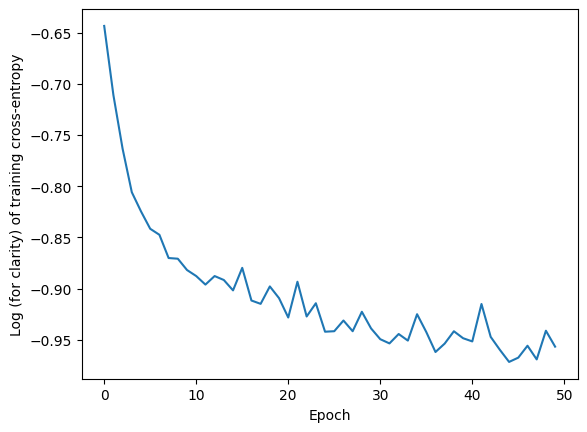

In [28]:
%%time
W_mini, train_ces = train_smreg(
    Train_X_new, train_Y, mb_size=32, lr=0.03, max_epoch=50, wanted_mbe = 13)

plt.plot(np.log(train_ces))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy')
# print(train_ces)

### Đánh giá mô hình 

In [29]:
y_pred = predict(W_mini, test_X)
y_pred

array([0, 1, 2, ..., 8, 8, 2], dtype=int64)

In [30]:
accuracy(y_pred, test_Y)

0.852

In [70]:
df = pd.DataFrame([[1]*len(test_Y[test_Y != y_pred]),test_Y[test_Y != y_pred],y_pred[test_Y != y_pred]], index=['count','actual','predict']).transpose()
df.groupby(['actual','predict']).sum('count').sort_values('count', ascending=False)

count
actual predict       
2      6          167
6      0          145
4      6          137
0      6          126
2      4          114
6      2           68
       4           67
4      2           54
7      9           50
3      6           42
5      7           41
7      5           41
9      7           40
0      3           33
4      3           32
3      0           29
8      6           26
6      3           24
3      1           22
5      9           21
9      5           18
1      3           16
2      0           16
3      4           15
6      8           14
0      8           12
3      2           10
2      8           10
       3            9
0      2            8
1      6            7
8      0            6
       5            6
5      8            6
8      3            5
6      1            5
8      4            4
       7            4
       2            3
0      1            3
4      8            3
5      1            2
2      1            2
1      5            2
8      9            2
0      5            2
6      5            1
5      6            1
       3            1
7      8            1
5      0            1
4      1            1
       0            1
3      8            1
1      2            1
0      9            1
9      8            1